# CUNY IS 622 Final Project

### Introduction

The objective of this project is to build a recommendation system for restaurants using collaborative filtering. The process of identifying similar users and recommending what similar users like is called collaborative filtering. This project is structured in the following manner:
1.	Exploratory data analysis
2.	Neighborhood-based CF recommender
3.	Predict a rating that user gives a restaurant that the user has not encountered before
4.	Error analysis


Import necessary packages and setup parameters

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [33]:
fulldf=pd.read_csv("/users/bcarancibia/CUNY_IS_622/FinalProject/bigdf.csv")
fulldf.head(2)

user_id             business_id                 date               review_id  stars  usefulvotes_review user_name                         categories            biz_name   latitude   longitude  business_avg  business_review_count  user_avg  user_review_count
0  rLtl8ZkDX5vH5nAx9C3q5Q  9yKzy9PApeiPPOUJEtnvkg  2011-01-26 00:00:00  fWKvX83p0-ka4JS3dc6E5A      5                   5     Jason  [Breakfast & Brunch, Restaurants]  Morning Glory Cafe  33.390792 -112.012504       3.87156                    109  3.796954                197
1  SBbftLzfYYKItOMFwOTIJg  9yKzy9PApeiPPOUJEtnvkg  2008-05-04 00:00:00  DASdFe-g0BgfN9J2tanStg      5                   1  Jennifer  [Breakfast & Brunch, Restaurants]  Morning Glory Cafe  33.390792 -112.012504       3.87156                    109  3.473684                 57

## Exploratory Data Analysis

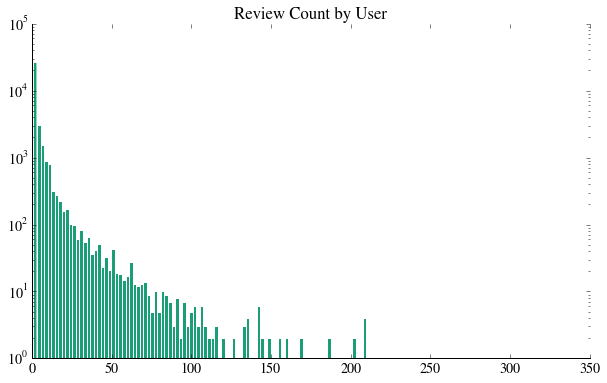

In [3]:
user_review_count=fulldf.groupby('user_id').review_id.count()  #using groupby function on fulldf to count number of reviews per user

bin_size=len(np.unique(user_review_count.values))    #getting the size of unique number to calculate bin size
fig,ax=plt.subplots()

ax.hist(user_review_count,bins=bin_size, log=True)    #plots histogram with log and bin size calculated above
ax.set_title('Review Count by User')     #title
ax.spines['top'].set_visible(False)      #removes top border
ax.spines['right'].set_visible(False)   #removes right border

plt.show()

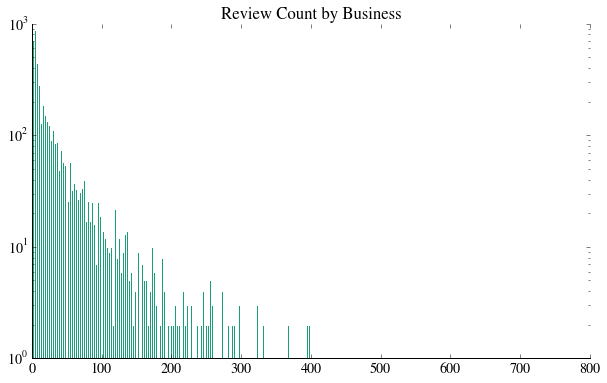

In [4]:
#using groupby function on fulldf to count number of reviews per business
business_review_count=fulldf.groupby('business_id').review_id.count() 

bin_size=len(np.unique(business_review_count.values))    #getting the size of unique number to calculate bin size
fig,ax=plt.subplots()

ax.hist(business_review_count,bins=bin_size, log=True)  #plots histogram with log and bin size calculated above
ax.set_title('Review Count by Business')   #title
ax.spines['top'].set_visible(False)        #removes top border
ax.spines['right'].set_visible(False)      #removes right border

plt.show()

In [5]:
businesses=len(fulldf.business_id.unique())     #counts number of unique businesses in fulldf
users=len(fulldf.user_id.unique())             #counts number of unique users in fulldf

print 'Businesses: %d | Users: %d' %(businesses,users)

Businesses: 4503 | Users: 34789


In [6]:
#grouping by businesses and calculating the average rating using 'stars'
average_rating_rest=fulldf.groupby('business_id').agg({'stars':np.mean})  
plt.hist(average_rating_rest.stars,bins=5)   #plotting histogram and using 5 as bin size because rating spans from 0-5
plt.show()

In [7]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

In [8]:
import re

#computing a subset from large dataframe where number of business reviews are more than 150 and user reviews more than 60
smalldf=fulldf[(fulldf.business_review_count>150) & (fulldf.user_review_count>60)]  
smalldf=recompute_frame(smalldf)   #usign the recompute function provided above to re-evaluate the average in smalldf
smalldf_unique_users=np.unique(smalldf.user_id).size   #getting number of unique users in new df 
smalldf_items=smalldf.shape[0]     #getting nuber of entries (rows) in new df

print 'Items: %d' %smalldf_items
print 'Unique Users: %d' %smalldf_unique_users

Items: 6165
Unique Users: 240


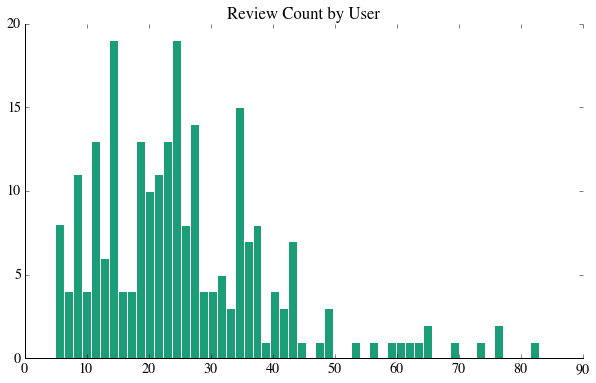

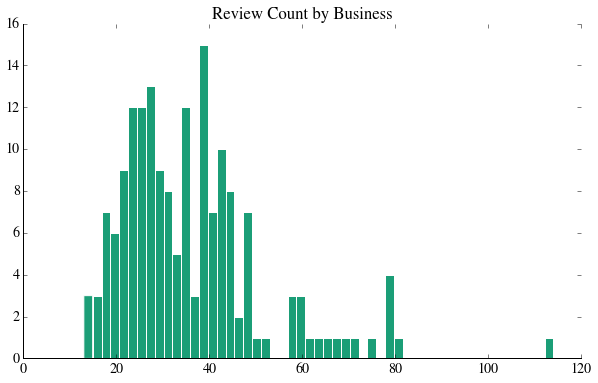

In [9]:
def plot_review_count(column,title):
    
    #groups by the column name passed and then counts the number of reviews in each group
    business_review_count=smalldf.groupby(column).review_id.count()   
    bin_size=len(np.unique(business_review_count.values))  #gets the bin size by looking at the unique values
    fig,ax=plt.subplots()
    
    ax.hist(business_review_count,bins=bin_size)  #plots the histogram 
    ax.set_title(title)  #title
    ax.spines['top'].set_visible(False)  #removes top border
    ax.spines['right'].set_visible(False)   #removes right border
    
    plt.show()
    
plot_review_count('user_id','Review Count by User')  #plot review count by user in smalldf using function defined above

plot_review_count('business_id','Review Count by Business') #plot review count by business in smalldf using function defined above

Overall Mean: 3.87


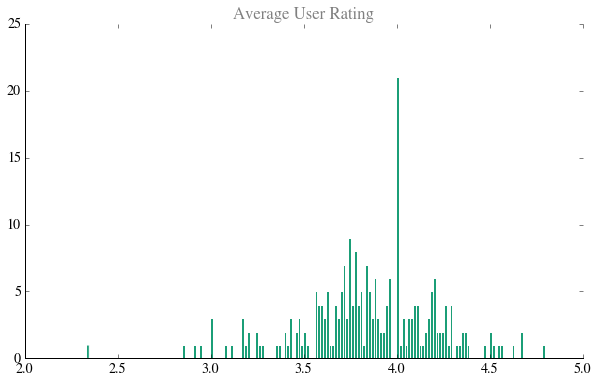

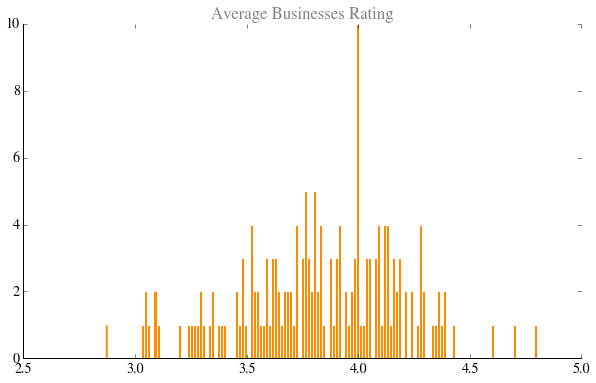

In [10]:
overall_mean=smalldf.stars.mean()
print 'Overall Mean:',round(overall_mean,2)

fig,ax=plt.subplots()
smalldf_users=smalldf[['user_id','user_avg']].drop_duplicates().user_avg

user_bin_size=np.unique(smalldf_users).size
plt.hist(smalldf_users,bins=user_bin_size)
ax.set_title('Average User Rating',color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

fig,ax=plt.subplots()
smalldf_businesses=smalldf[['business_id','business_avg']].drop_duplicates().business_avg

business_bin_size=np.unique(smalldf_businesses).size
plt.hist(smalldf_businesses,bins=business_bin_size,color='darkorange')
ax.set_title('Average Businesses Rating',color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [12]:
from scipy.stats.stats import pearsonr
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common==0:
        rho=0.
    else:
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        rho=pearsonr(diff1, diff2)[0]
    return rho

Mean support is: 6.84679722562


(array([  7.02000000e+03,   4.98700000e+03,   1.79400000e+03,
          5.90000000e+02,   1.95000000e+02,   7.60000000e+01,
          2.20000000e+01,   1.00000000e+01,   1.00000000e+01,
          2.00000000e+00]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ]),
 <a list of 10 Patch objects>)

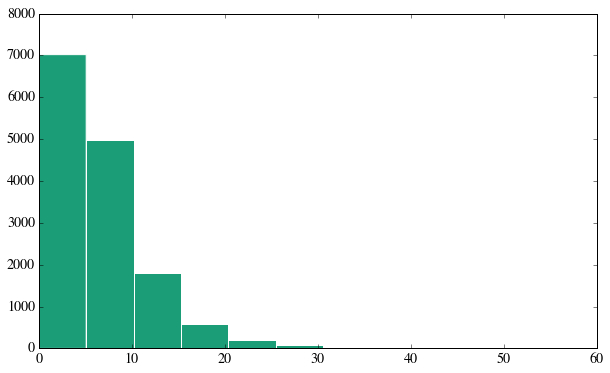

In [11]:
restaurants=smalldf.business_id.unique()
supports=[]
for i,rest1 in enumerate(restaurants):
    for j,rest2 in enumerate(restaurants):
        if  i < j:
            rest1_reviewers = smalldf[smalldf.business_id==rest1].user_id.unique()
            rest2_reviewers = smalldf[smalldf.business_id==rest2].user_id.unique()
            common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
            supports.append(len(common_reviewers))
print "Mean support is:",np.mean(supports)
plt.hist(supports)

### Calculate Similarity

In [13]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

In [14]:
def calculate_similarity(rest1,rest2,df,similarity_func):     #calculates similarity between 2 restaurants using some similarity function
    
    reviewers_rest1=df[df.business_id==rest1].user_id   #gets all the user ids from df for rest1
    reviewers_rest2=df[df.business_id==rest2].user_id   #gets all the user ids from df for rest2
    
    #computes the intersection (common reviewers) by comparing reviewers for rest1 and rest2
    reviewers_common=set(reviewers_rest1).intersection(reviewers_rest2) 
    n_common=len(reviewers_common)  #computes the number of common reviewers (length)
    
    #gets the reviews by common reviewers found above for rest1 and rest2
    reviews_rest1=get_restaurant_reviews(rest1, df, reviewers_common) 
    reviews_rest2=get_restaurant_reviews(rest2, df, reviewers_common) 
    
    similarity=similarity_func(reviews_rest1,reviews_rest2,n_common)  #using similarity functino defined above to compute similarity
    
    #checks to see if similarity is NaN and if true, sets similarity to zero
    if np.isnan(similarity): 
        similarity=0
        
    return (similarity,n_common)

In [15]:
class Database:
    "A class representing a database of similaries and common supports"
    
    def __init__(self, df):
        "the constructor, takes a reviews dataframe like smalldf as its argument"
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)
        
    def populate_by_calculating(self, similarity_func):
        """
        a populator for every pair of businesses in df. takes similarity_func like
        pearson_sim as argument
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1 < i2:
                    sim, nsup=calculate_similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sup[i1][i1]=nsup
                    

    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

In [16]:
db=Database(smalldf)
db.populate_by_calculating(pearson_sim)
db.get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

In [17]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim
import operator

#finds k length of nearest restaurants from set_of_restaurants to the restaurant_id provided using similarity
def knearest(restaurant_id,set_of_restaurants,dbase,k,reg):  
    
    set_of_restaurants=set_of_restaurants[set_of_restaurants!=restaurant_id]  #takes out the restaurant id provided from the set
    
    k_list=[]
    
    for rest_id in set_of_restaurants: 
        n_common=dbase.get(restaurant_id, rest_id)[1]        #using .get on instance of database class, gets common users
        sim=dbase.get(restaurant_id, rest_id)[0]            #using .get on instane of database class, gets similarity
        shrunk_sim_score=shrunk_sim(sim, n_common, reg=reg)    #applies shrunk_sim function to get new similarity after applying reg
        k_list.append((rest_id,shrunk_sim_score,n_common))       #appends the rest id, sim, and common users as a tuple in list
        
    k_list.sort(key=operator.itemgetter(1),reverse=True)      #sorts the list using shrunk sim
    
    if k is None:k=7      #if k is not provided, default is set to 7
        
    return k_list[:k]    #returns a list of k length

In [18]:
testbizid="eIxSLxzIlfExI6vgAbn2JA"
testbizid2="L-uPZxooP_ziXCtRrWi8Pw"

def biznamefromid(df, theid):
    return df['biz_name'][df['business_id']==theid].values[0]
def usernamefromid(df, theid):
    return df['user_name'][df['user_id']==theid].values[0]
print testbizid, biznamefromid(smalldf,testbizid)
print testbizid2, biznamefromid(smalldf, testbizid2)

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


## Calculate Nearest Neighbors Similarities Recommendation

In [19]:
tops=knearest(testbizid, smalldf.business_id.unique(), db, k=7, reg=3.)
print "For ",biznamefromid(smalldf, testbizid), ", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops):
    print i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc

For  Lobbys Beef Burgers Dogs , top matches are:
0 La Condesa Gourmet Taco Shop | Sim 0.598714448434 | Support 6
1 Citizen Public House | Sim 0.571428571429 | Support 4
2 FnB | Sim 0.527129890943 | Support 5
3 Defalco's Italian Grocery | Sim 0.519456555658 | Support 6
4 Republic Ramen + Noodles | Sim 0.519140146937 | Support 5
5 unPhogettable | Sim 0.5 | Support 3
6 Haus Murphy's | Sim 0.467637235308 | Support 3


In [20]:
tops2=knearest(testbizid2, smalldf.business_id.unique(), db, k=7, reg=3.)
print "For ",biznamefromid(smalldf, testbizid2), ", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops2):
    print i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc

For  Café Monarch , top matches are:
0 Postino Arcadia | Sim 0.625 | Support 5
1 The Main Ingredient Ale House And Café | Sim 0.571428571429 | Support 4
2 Brio Tuscan Grille | Sim 0.571428571429 | Support 4
3 Kazimierz World Wine Bar | Sim 0.5 | Support 3
4 Harlow's Cafe | Sim 0.5 | Support 3
5 The Fry Bread House | Sim 0.5 | Support 3
6 Cien Agaves Tacos & Tequila | Sim 0.5 | Support 3


## Calculate User Top Choices

In [21]:
def get_user_top_choices(user_id, df, numchoices=5):
    "get the sorted top 5 restaurants for a user by the star rating the user gave them"
    udf=df[df.user_id==user_id][['business_id','stars']].sort(['stars'], ascending=False).head(numchoices)
    return udf
testuserid="7cR92zkDv4W3kqzii6axvg"
print "For user", usernamefromid(smalldf,testuserid), "top choices are:" 
bizs=get_user_top_choices(testuserid, smalldf)['business_id'].values
[biznamefromid(smalldf, biz_id) for biz_id in bizs]

For user Vern top choices are:


['Tee Pee Mexican Food',
 'Local Breeze',
 "Carly's Bistro",
 'District American Kitchen and Wine Bar',
 'Sonora Mesquite Grill']

In [22]:
def get_top_recos_for_user(userid,df,dbase,n,k,reg):
    
    if k is None: k=8    #sets default k as 8
    
    #gets the top choices of restaurants for user of n length    
    top_choices=get_user_top_choices(userid, df, numchoices=n).business_id.values  
    
    #loop below finds the nearest restaurants for each top choice defined above and appends them to a list
    nearest_list=[]
    for top_choice_restid in top_choices:      
        #using knearest function to find nearest restaurants using similarity 
        nearest_list.append(knearest(top_choice_restid,df.business_id.unique(),dbase,k,reg))  
    
    #extract business id's from the return of knearest function, which is multiple list consisting of tuples in a list
    b_id=[tuples[0] for tuples in sum(nearest_list,[])]  
    #droping duplicates from the list created above
    b_id=list(set(b_id)) 
    
    #making a dataframe with information of only the nearest list businesses 
    subdf=df[df['business_id'].isin(b_id)]
    user_rated=list(subdf[subdf.user_id==testuserid].business_id.values) #find values this user has rated (user rating)
    subdf = subdf[-subdf['business_id'].isin(user_rated)]    #takes out the business ids which this user has already rated
    
    #makes a smaller df with only business_id and business_average
    #groups by businesses and computes the mean (i could use stars to since business avg is alredy the mean)
    df_mean=subdf[['business_id','business_avg']].groupby('business_id')['business_avg'].mean()
    
    #makes a list of tuples with business ids and averages 
    top_recomen=[(rest,avg) for rest,avg in zip(df_mean.index, df_mean.values)]
    top_recomen.sort(key=operator.itemgetter(1),reverse=True)   #sorts the list by using average
    
    
    return top_recomen

In [23]:
print "For user", usernamefromid(smalldf,testuserid), "the top recommendations are:"
toprecos=get_top_recos_for_user(testuserid, smalldf, db, n=5, k=7, reg=3.)
for biz_id, biz_avg in toprecos:
    print biznamefromid(smalldf,biz_id), "| Average Rating |", biz_avg

For user Vern the top recommendations are:
Rokerij | Average Rating | 4.37931034483
Wildfish Seafood Grille | Average Rating | 4.29411764706
Defalco's Italian Grocery | Average Rating | 4.23255813953
Cornish Pasty Company | Average Rating | 4.20689655172
Pappadeaux Seafood Kitchen | Average Rating | 4.18518518519
Four Peaks Brewing Co | Average Rating | 4.16666666667
Yasu Sushi Bistro | Average Rating | 4.07692307692
Pho Thanh | Average Rating | 4.04761904762
Carolina's Mexican Food | Average Rating | 3.91176470588
Pita Jungle | Average Rating | 3.91176470588
The Main Ingredient Ale House And Café | Average Rating | 3.89743589744
Malee's Thai Bistro | Average Rating | 3.875
Butterfield's Pancake House | Average Rating | 3.83333333333
Joe's Real BBQ | Average Rating | 3.81578947368
Arcadia Farms Cafe | Average Rating | 3.79310344828
Delux | Average Rating | 3.77611940299
CherryBlossom Noodle Cafe | Average Rating | 3.75
SanTan Brewing Company | Average Rating | 3.73076923077
Republic Ra

## Predict User Rating

In [24]:
def knearest_amongst_userrated(restaurant_id,user_id,df,dbase,k,reg):
    '''#took this line from HW's get_user_top_choices function without the head(n) limit
    set_business_id=df[df.user_id==user_id][['business_id','stars']].sort(['stars'], ascending=False).business_id.values
    set_business_id=df[df.user_id==user_id][['business_id','stars']]'''
   
    if k is None: k=7  #setting k to 7 as default
        
    #using get_user_top_choices function from above with a very high n values to capture all the data     
    set_business_id=get_user_top_choices(user_id, df, numchoices=500).business_id.values
    
    knearest_rest= knearest(restaurant_id,set_business_id,dbase,k,reg)   #getting knearest rest from the top choices
    
    return knearest_rest

def rating(df,dbase,restaurant_id,user_id,k,reg):
    
    if k is None: k=7 #setting k to 7 as default
        
    #using the function from above, getting nearest rest that were rated by the user    
    knearest_rest=knearest_amongst_userrated(restaurant_id,user_id,df,dbase,k,reg)
    
    '''y_um_baseline is over complete dataframe''' 
    y=df.stars.mean() #computes the y bar which is average of rating over whole dataframe
    y_u=df[df.user_id==user_id].user_avg.unique().mean()  #computes average for a given user over whole data frame
    y_m=df[df.business_id==restaurant_id].stars.mean()     #computes average for a given business over whole data frame
    
    #calculates y_um_baseline using the formula provided
    y_um_baseline=y+(y_u-y)+(y_m-y)  
    
    
    '''smj_sum is the denominator in the formula, sum of similaritie in knearest restaurants'''
    smj_sum=sum([sim[1] for sim in knearest_rest])
    
    
    '''calculate numerator from knearest restaurant'''
    knearest_bid=[b_id[0] for b_id in knearest_rest]  #gets business ids from knearest
    knearest_df=df[df['business_id'].isin(knearest_bid)]  #creates sub dataframe for the knearest rest
    
    y_baseline_uj=df.stars.mean() #y bar for uj, same as y bar for um
    yu_baseline_uj=knearest_df[knearest_df['user_id']==user_id].user_avg.unique()[0]   #gets user u average for restaurant j
    
    numerator=0
    
    for tupple in knearest_rest:  #loops over the tuples in knearest rest 
        
        #get business average for a restaurant from knearest rest
        yj_baseline_uj=knearest_df[knearest_df['business_id']==tupple[0]].stars.mean()
        
        #gets user u rating for jth restaurant from knearest dataframe 
        yuj = knearest_df[(knearest_df['business_id']==tupple[0])&(knearest_df['user_id']==user_id)].stars.values[0]
        
        #calculates y_uj_baseline using baseline formula provided
        yuj_baseline=y_baseline_uj+(yu_baseline_uj-y_baseline_uj)+(yj_baseline_uj-y_baseline_uj)
        
        smj=tupple[1]  #gets the similarity
        
        #a sum function which calculates the numerator using the formula provided
        numerator=numerator+(smj*(yuj-yuj_baseline))
    
    #checks to make sure denominator is not 0, if it is 0 then passes the y_um_baseline for y_um
    if smj_sum==0:
        y_um=y_um_baseline
    else:
        y_um=y_um_baseline+(numerator/smj_sum)   #compute the y_um using the formula provided
    
    return y_um

In [25]:
print "User Average", smalldf[smalldf.user_id==testuserid].stars.mean(),"for",usernamefromid(smalldf,testuserid)
print "Predicted ratings for top choices calculated earlier:"
for biz_id,biz_avg in toprecos:
    print biznamefromid(smalldf, biz_id),"|",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.),"|","Average",biz_avg 

User Average 3.5652173913 for Vern
Predicted ratings for top choices calculated earlier:
Rokerij | 4.71714023074 | Average 4.37931034483
Wildfish Seafood Grille | 4.27594504172 | Average 4.29411764706
Defalco's Italian Grocery | 3.822223075 | Average 4.23255813953
Cornish Pasty Company | 4.62810510121 | Average 4.20689655172
Pappadeaux Seafood Kitchen | 4.08845573953 | Average 4.18518518519
Four Peaks Brewing Co | 4.26174734161 | Average 4.16666666667
Yasu Sushi Bistro | 4.61103444018 | Average 4.07692307692
Pho Thanh | 4.10317798035 | Average 4.04761904762
Carolina's Mexican Food | 4.31700962152 | Average 3.91176470588
Pita Jungle | 4.40378787384 | Average 3.91176470588
The Main Ingredient Ale House And Café | 3.88743659505 | Average 3.89743589744
Malee's Thai Bistro | 4.39994642565 | Average 3.875
Butterfield's Pancake House | 3.77611292043 | Average 3.83333333333
Joe's Real BBQ | 3.97629233918 | Average 3.81578947368
Arcadia Farms Cafe | 3.14091506468 | Average 3.79310344828
Delux |

In [26]:
def get_other_ratings(restaurant_id, user_id, df):
    "get a user's rating for a restaurant and the restaurant's average rating"
    choice=df[(df.business_id==restaurant_id) & (df.user_id==user_id)]
    users_score=choice.stars.values[0]
    average_score=choice.business_avg.values[0]
    return users_score, average_score

In [27]:

print "for user",usernamefromid(smalldf,testuserid), 'avg', smalldf[smalldf.user_id==testuserid].stars.mean() 
for biz_id in bizs:
    print "----------------------------------"
    print biznamefromid(smalldf, biz_id)
    print "Predicted Rating:",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.) 
    u,a=get_other_ratings(biz_id, testuserid, smalldf)
    print "Actual User Rating:",u,"Avg Rating",a

for user Vern avg 3.5652173913
----------------------------------
Tee Pee Mexican Food
Predicted Rating: 3.52640184162
Actual User Rating: 5 Avg Rating 3.04347826087
----------------------------------
Local Breeze
Predicted Rating: 4.2280987611
Actual User Rating: 5 Avg Rating 4.0
----------------------------------
Carly's Bistro
Predicted Rating: 3.99008654065
Actual User Rating: 5 Avg Rating 3.5
----------------------------------
District American Kitchen and Wine Bar
Predicted Rating: 3.80281696528
Actual User Rating: 4 Avg Rating 3.55263157895
----------------------------------
Sonora Mesquite Grill
Predicted Rating: 4.08382083034
Actual User Rating: 4 Avg Rating 4.38461538462


## Error Analysis

In [29]:
def compare_results(stars_actual, stars_predicted, ylow=-10, yhigh=15, title=""):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    fig=plt.figure()
    #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    
    
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label="predicted")
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label="slope 1")
    xp=[1,2,3,4,5]
    yp=df.groupby('actual').predicted.mean().values
    plt.plot(xp,yp,'k', label="means")
    sig=df.groupby('actual').predicted.std().values
    plt.fill_between(xp, yp - sig, yp + sig, 
                 color='k', alpha=0.2)
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.legend(frameon=False)
    remove_border()
    plt.grid(False)
    plt.title(title)
    print np.mean(np.abs(df.predicted) < 15)

0.999837793998
0.999675587997
0.993349553933
0.994484995945


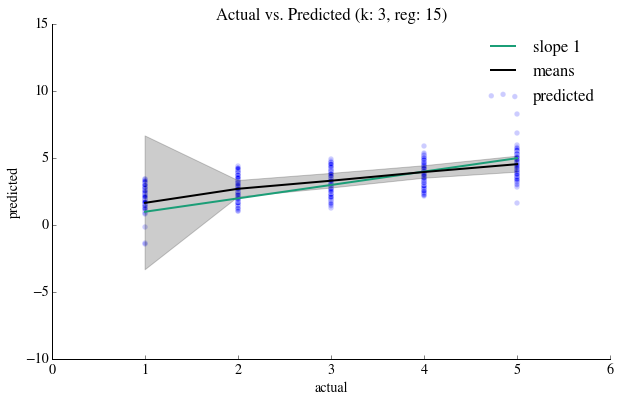

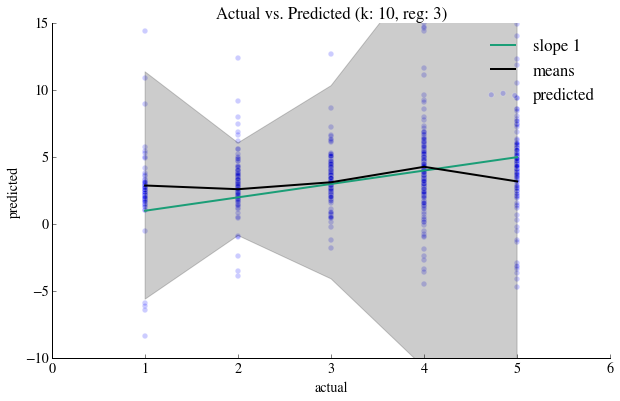

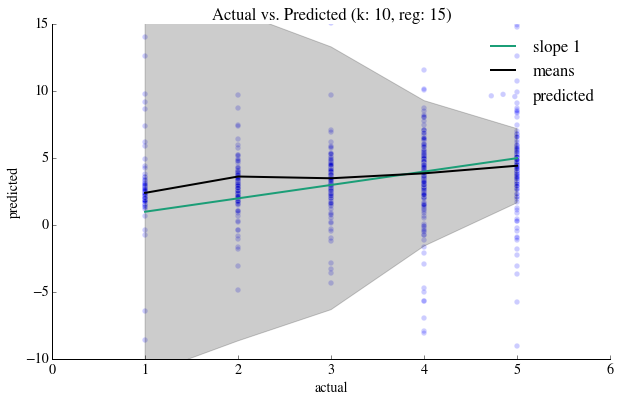

In [31]:

k=[3,3,10,10]   #list of all the k
reg=[3,15,3,15]  #list of reg

#loops over the k and reg to plot the graphs
for k_i,reg_i in zip(k,reg):
    
    #empty arrays
    stars_predicted=np.array([])   
    stars_actual=np.array([])
    
    #loops ove rthe df to get different values
    for stars,restid,userid in zip(smalldf.stars,smalldf.business_id,smalldf.user_id):
        
        #gets the predicted stars from rating function and appends it to array
        stars_predicted=np.append(stars_predicted,rating(smalldf,db,restid,userid,k=k_i,reg=reg_i))
        
        #get the actual rating and appends it to array
        stars_actual=np.append(stars_actual,stars)
    
    #using compare_results function plots the graph for actual vs prediction at different k and reg
    compare_results(stars_actual, stars_predicted, ylow=-10, yhigh=15, title="Actual vs. Predicted (k: %d, reg: %d)"%(k_i,reg_i))